---
title: "Imaging - Convolution between an image and a filtering kernel"
author: "MLun Wong"
date: "2024-01-06"
categories: [Python,Code,Convolution,]
jupyter: conda-env-data_analysis-py
---

```{=html}
<div class="serif-content">
```

# Convolution and Fourier Transforms in Discrete Spaces

The equivalence of convolution in the image domain and element-wise multiplication in the Fourier domain is a foundational concept in image processing, applicable even within discrete grid spaces. Textbooks often present this relationship as follows:

$$
\begin{align}
I(\vec{x}) = f(\vec{x}) * g(\vec{\tau}) &= \sum_{\vec{\tau}} f(\vec{x} - \vec{\tau}) \cdot g(\vec{\tau}) \\
&= \mathscr{F}^{-1}\left\{\mathscr{F}[f(\vec{x})] \cdot \mathscr{F}[g(\vec{\tau})]\right\} \tag{1}
\end{align}
$$

Here, $I(\vec{x})$ represents the resulting n-dimensional image after convolution, with $x_i \in X$ and $\tau_i \in T$ such that the domain $T \subseteq X$. This formulation is straightforward when the convolution involves images of the same domain (i.e., identical size). However, the scenario of interest involves the special case where $T \neq X$, specifically $T \subset X$. The question then arises: how do we compute this

$$
\mathscr{F}[f(\vec{x})] \cdot \mathscr{F}[g(\vec{\tau})]
$$

Practically when the kernel $g(\vec{\tau})$ and the image $f(\vec{x})$ differ in size?

In such cases, direct element-wise multiplication is not feasible. This dilemma is seldom addressed in textbooks, leaving a gap in practical understanding. So what can we do here? 

In reality, you can thought of the scenario as convolving the image with a kernel that is centered and padded with zeros elsewhere. The most straightforward practical approach is to equalize the domains by padding the kernel $g(\vec{\tau})$ with zeros, effectively expanding the domain $T$ to match $X$.

This method ensures that the Fourier transform of the padded kernel has the same dimensionality as the Fourier transform of the image, allowing for the required element-wise multiplication in the Fourier space.

# Example Implementation

In [2]:
'''Import libraries'''
import numpy as np
from IPython.display import *
from skimage.color import rgb2gray
from skimage.io import imread
import scipy.ndimage as ndimage
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


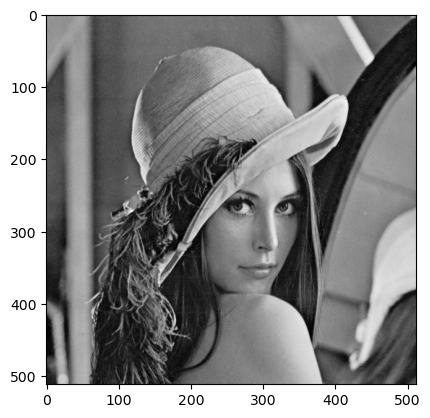

In [3]:
#| label: Lena
#| fig-cap: "Fig.1 Lena.png. We are using this image as our input."
#| output-location: column

'''Load Images'''
# Generate an example 512x512 image and 3x3 kernel
image = imread("./lena.png").astype('float32')
image = rgb2gray(image[...,:3])

plt.imshow(image,cmap='gray')
plt.show()

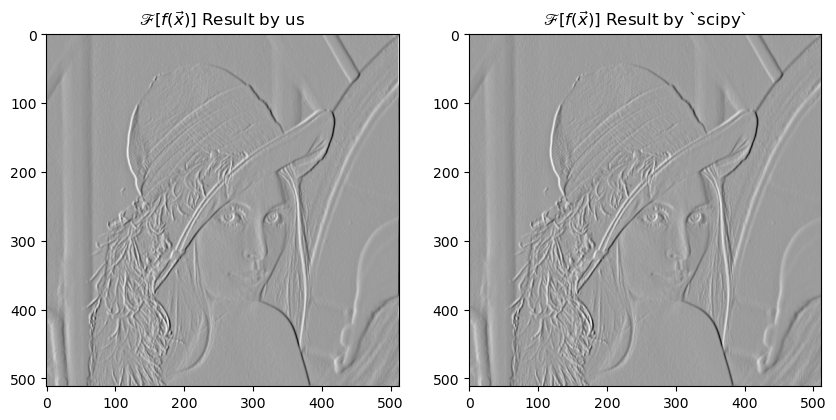

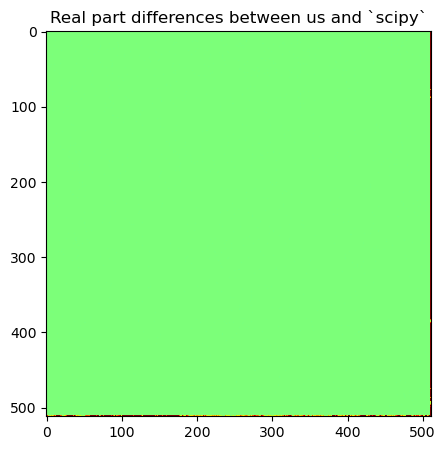

In [4]:
#| layout-align: center
#| layout: [2, 1]

def out_conv(im, kn):
    """Convolution"""
    fftkern = np.fft.fftshift(np.fft.fft2(np.pad(kn,
                            [[256-1, 256-2], [256-1,256-2]],
                            constant_values=0,
                            mode='constant')
                    ))
    fftimage = np.fft.fftshift(np.fft.fft2(im))

    # Multiplication
    fftoutput = fftkern*fftimage

    # Inverse fourier transform
    out = np.fft.ifftshift(np.fft.ifft2(np.fft.fftshift(fftoutput)))        
    return np.real(out)

# Define 3 by 3 Kernel
kern = np.array([[1, 0, -1], [1, 0, -1], [1, 0, -1]], dtype=np.float32)
ioutput = out_conv(image, kern)

# Scipy output as ground truth
spoutput = ndimage.filters.convolve(image, kern)

fig = plt.figure(figsize=(10, 5))
ax1, ax2 = [fig.add_subplot(i) for i in [121, 122]]
ax1.imshow(ioutput, cmap="Greys_r")
ax2.imshow(spoutput, cmap="Greys_r")
ax1.set_title(r"$\mathscr{F}[f(\vec{x})]$ Result by us")
ax2.set_title(r"$\mathscr{F}[f(\vec{x})]$ Result by `scipy`")


# calculate and show the difference
diff = np.abs(spoutput - ioutput)
fig = plt.figure(figsize=(5, 5))
ax1 = fig.add_subplot(111)
ax1.imshow(diff, cmap='jet', vmin=-10, vmax=10)
ax1.set_title("Real part differences between us and `scipy`")

# display(Markdown("## Results"))
plt.show()


Seems like we have repeated the `conv` function `scipy` implemented! But did we really? Lets take closer to the edge of the image:

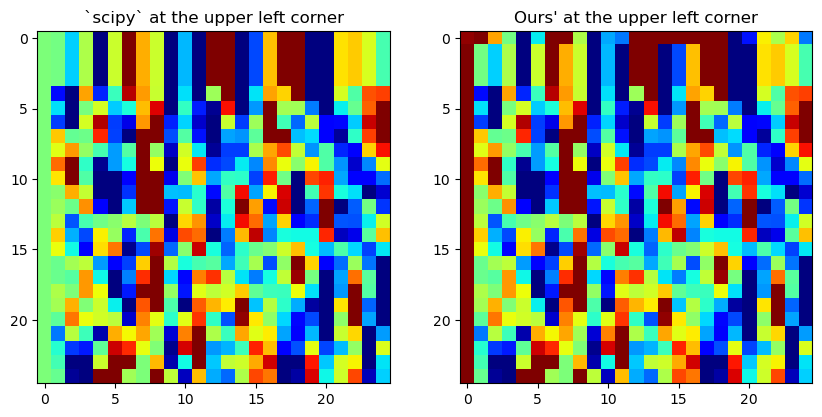

In [5]:
#| label: Differences
#| code-fold: true
#| fig-cap: "Fig.2 Difference between our implementation of convolution and scipy"

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(spoutput[:25, :25], cmap='jet', vmin=-10, vmax=10)
ax[1].imshow(ioutput[:25, :25], cmap='jet', vmin=-10, vmax=10)
ax[0].set_title("`scipy` at the upper left corner")
ax[1].set_title("Ours' at the upper left corner")
plt.show()

Wow, what happened here? As you can see, our implementation differs with `scipy` at the edge of the output image. So what is actually happening? To keep things short, this has to do with how the kernel was convolved at the edge of the image. FFT was implemented based on the assumption that the image is periodic outside of the presented discrete domain $X$. Therefore, when the convolve (in $x$ space) reaches the edge, its wrapping back the other end of the image. 

# Padding methods

## Zero-padding (Explicit Padding): 

This is the most straightforward approach and the one used initially in this workbook, where zeros are added to the borders of the kernel image. Now remember that FFT requires the input to have a dimension as a power of 2, this means that for odd number sized kernels, the padding is always asymetric. 

## Implicit Padding in Fast Fourier Transform (FFT): 

When using FFT for convolution, some libraries and frameworks automatically handle padding. The input signals are implicitly padded with zeros to the next power of two or to a size that allows for the most efficient computation by the FFT algorithm.

## Valid Convolution: 

In some cases, especially in neural networks, convolutions are performed without padding, known as 'valid' convolution. This approach results in an output that is smaller than the input because only the regions where the kernel and input fully overlap are computed.

## Reflective or Symmetric Padding: 

Instead of padding with zeros, the border values are reflected or mirrored across the edge. This can help reduce the artifacts introduced by the hard boundary of zero-padding and can be more appropriate for certain types of data, such as images.

## Circular Padding: 

This involves wrapping the signal around, effectively creating a toroidal topology. This is the inherent assumption in FFT-based convolution, but it can also be done explicitly in the spatial domain.

## Replicate Padding: 

The edge values are replicated to the padded regions. This can sometimes produce more natural results than zero-padding, particularly for image processing tasks.

## Partial Convolutions: 

Used mainly in image inpainting, partial convolutions involve a mask that indicates which pixels are valid, allowing the convolution to be reweighted to ignore the contribution from missing or padded values.

## Dilated Convolutions: 

Also known as atrous convolutions, these involve spacing out the kernel elements, which allows for a larger receptive field without increasing the computational complexity. This is not directly a padding method but can be used to reduce the need for padding by controlling the resolution at which feature maps are computed.

## Strided Convolutions: 

By skipping input values with a certain stride, these convolutions effectively downsample the input. This can also reduce the need for padding by adjusting the output size.



```{=html}
</div>
```